In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import torchvision.transforms as transforms
import tqdm
from torch.utils.data import Dataset
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import os

In [40]:
import sys
sys.path.append("..")

In [41]:
class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.all_image_names = self.csv[:]["filename"]
        self.all_images_index = self.csv[:]["ind"]
        self.all_labels = np.array(self.csv.drop(["filename", "ind"], axis=1))
        self.train_ratio = int(0.6 * len(self.csv))
        self.valid_ratio = int(0.2 * len(self.csv))
        self.test_ratio =  len(self.csv) - self.train_ratio - self.valid_ratio
 
        # set the training data images and labels
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[: self.train_ratio])
            self.labels = list(self.all_labels[: self.train_ratio])
            # define the training transforms
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                ]
            )
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[self.train_ratio : self.train_ratio+self.valid_ratio])
            self.labels = list(self.all_labels[self.train_ratio : self.train_ratio+self.valid_ratio])
#             # define the validation transforms
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                ]
            )
        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif self.test == True and self.train == False:
            print(f"Number of validation images: {self.test_ratio}")
            self.image_names = list(self.all_image_names[-self.test_ratio:])
            self.labels = list(self.all_labels[-self.test_ratio:])
            # define the test transforms
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                ]
            )

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image = cv2.imread(f"../data/raw_images/{self.image_names[index]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        image = self.transform(image)
        targets = self.labels[index]

        return {
            "image": torch.tensor(image, dtype=torch.float32),
            "label": torch.tensor(targets, dtype=torch.float32),
        }

In [42]:
class LeNet5_convnet(nn.Module):
    def __init__(self):

        super(LeNet5_convnet, self).__init__()

        # CL1: 3 x 144 x 256 --> 50 x 144 x 256
        self.conv1 = nn.Conv2d(3, 50, kernel_size=3, padding='same')

        # MP1: 50 x 144 x 256 --> 50 x 72 x 128 
        self.pool1 = nn.MaxPool2d(2, 2)

        # CL2: 50 x 72 x 128 --> 100 x 72 x 128
        self.conv2 = nn.Conv2d(50, 100, kernel_size=3, padding='same')

        # MP2: 100 x 72 x 128 --> 100 x 36 x 64
        self.pool2 = nn.MaxPool2d(2, 2)

        # LL1:   100 x 36 x 64 = 230400 -->  100
        self.linear1 = nn.Linear(230400, 100)

        # LL2:   100  -->  6
        self.linear2 = nn.Linear(100, 6)

    def forward(self, x):

        # CL1: 3 x 144 x 256 --> 50 x 144 x 256
        x = self.conv1(x)
        x = F.relu(x)

        # MP1: 50 x 144 x 256 --> 50 x 72 x 128 
        x = self.pool1(x)

        # CL2: 50 x 72 x 128 --> 100 x 72 x 128
        x = self.conv2(x)
        x = F.relu(x)

        # MP2: 100 x 72 x 128 --> 100 x 36 x 64
        x = self.pool2(x)

        # LL1:   100 x 36 x 64 = 230400 -->  100
        x = x.view(-1, 230400)
        x = self.linear1(x)
        x = F.relu(x)

        # LL2:   100  -->  6
        x = self.linear2(x)

        return x


In [43]:
def get_error( outputs , labels, batch_size):
    lab = torch.where(outputs>=0.5,1,0)
    indicator = torch.where(lab!=labels, 1, 0)
    non_matches=torch.sum(indicator, axis=0)
    error = non_matches.float()/batch_size
    error = error.sum() / 6
    return error.item()

In [44]:
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    print("Training")
    model.train()
    counter = 0
    train_running_loss = 0.0
    train_running_error = 0.0
    for i, data in tqdm(
        enumerate(dataloader), total=int(len(train_data) / dataloader.batch_size)
    ):
        
        counter += 1
        data, target = data["image"].to(device), data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, target)
        train_running_loss += loss.detach().item()
        error = get_error( outputs.detach() , target, batch_size)
        train_running_error += error
        
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()

        
    train_loss = train_running_loss / counter
    total_error = train_running_error/counter
    return train_loss, total_error

In [45]:
def validate(model, dataloader, criterion, val_data, device):
    print("Validating")
    model.eval()
    counter = 0
    val_running_loss = 0.0
    val_running_error = 0.0
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader), total=int(len(val_data) / dataloader.batch_size)
        ):
            counter += 1
            data, target = data["image"].to(device), data["label"].to(device)
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            val_running_loss += loss.item()
            error = get_error( outputs, target, batch_size)
            val_running_error += error
        val_loss = val_running_loss / counter
        val_error = val_running_error / counter
    return val_loss, val_error

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from torch.utils.data import DataLoader

matplotlib.style.use("ggplot")
# initialize the computation device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
model = LeNet5_convnet()
net = model.to(device)

lr = 0.0001
epochs = 10
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()

In [48]:
train_csv = pd.read_csv("../data/processed/train.csv")
# train dataset
# train_csv_sample = train_csv.sample(frac=1, random_state=1)
train_csv_sample = train_csv
train_data = ImageDataset(train_csv_sample[:2000], train=True, test=False)
# validation dataset
valid_data = ImageDataset(train_csv_sample[:2000], train=False, test=False)
# train data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# validation data loader
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)



Number of training images: 1199
Number of validation images: 399


In [50]:
img = cv2.imread(f"./data/raw_images/0_8wewPn7TZfs_0.jpg")


img = train_data.__getitem__(0)
print(img["image"].shape)


torch.Size([3, 144, 256])


C:\Users\Rishabh\anaconda3\envs\deeplearn_course\lib\site-packages\ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [51]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, total_epoch_error = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss, valid_epoch_error = validate(model, valid_loader, criterion, valid_data, device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print("Train Error: ", total_epoch_error)
    print(f"Val Loss: {valid_epoch_loss:.4f}")
    print(f"Val Error: ", valid_epoch_error)
    

Epoch 1 of 10
Training


  0%|                                                                                           | 0/37 [00:00<?, ?it/s]C:\Users\Rishabh\anaconda3\envs\deeplearn_course\lib\site-packages\ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
38it [00:02, 17.06it/s]                                                                                                


Validating


13it [00:00, 21.47it/s]                                                                                                


Train Loss: 0.4452
Train Error:  0.19599781224602147
Val Loss: 0.5314
Val Error:  0.15504808036180642
Epoch 2 of 10
Training


38it [00:02, 17.29it/s]                                                                                                


Validating


13it [00:00, 21.58it/s]                                                                                                


Train Loss: 0.3251
Train Error:  0.14103618930829198
Val Loss: 0.6221
Val Error:  0.20192308265429276
Epoch 3 of 10
Training


38it [00:02, 17.19it/s]                                                                                                


Validating


13it [00:00, 21.83it/s]                                                                                                


Train Loss: 0.2524
Train Error:  0.09868421336930049
Val Loss: 0.6325
Val Error:  0.24198718483631426
Epoch 4 of 10
Training


38it [00:02, 17.16it/s]                                                                                                


Validating


13it [00:00, 20.86it/s]                                                                                                


Train Loss: 0.1919
Train Error:  0.06702302768826485
Val Loss: 0.5429
Val Error:  0.17027244315697596
Epoch 5 of 10
Training


38it [00:02, 17.11it/s]                                                                                                


Validating


13it [00:00, 21.44it/s]                                                                                                


Train Loss: 0.1478
Train Error:  0.05263158041787775
Val Loss: 0.6180
Val Error:  0.1862980815080496
Epoch 6 of 10
Training


38it [00:02, 16.91it/s]                                                                                                


Validating


13it [00:00, 20.96it/s]                                                                                                


Train Loss: 0.1231
Train Error:  0.04399671186202843
Val Loss: 0.7759
Val Error:  0.2524038530313052
Epoch 7 of 10
Training


38it [00:02, 16.52it/s]                                                                                                


Validating


13it [00:00, 19.17it/s]                                                                                                


Train Loss: 0.1022
Train Error:  0.03440241339175325
Val Loss: 0.6800
Val Error:  0.20152244143761122
Epoch 8 of 10
Training


38it [00:02, 16.72it/s]                                                                                                


Validating


13it [00:00, 19.81it/s]                                                                                                


Train Loss: 0.0788
Train Error:  0.023711623464661994
Val Loss: 0.7896
Val Error:  0.20713141789803138
Epoch 9 of 10
Training


38it [00:02, 15.51it/s]                                                                                                


Validating


13it [00:00, 19.28it/s]                                                                                                


Train Loss: 0.0660
Train Error:  0.01932565838490662
Val Loss: 0.8193
Val Error:  0.18669872616346067
Epoch 10 of 10
Training


38it [00:02, 15.91it/s]                                                                                                


Validating


13it [00:00, 19.31it/s]                                                                                                

Train Loss: 0.0542
Train Error:  0.015213816291897705
Val Loss: 0.8471
Val Error:  0.1939102611862696


In [52]:
# test_csv = pd.read_csv("../data/processed/test/test.csv")
actors = train_csv.columns.values[2:]
print('actors: ', actors)
# prepare the test dataset and dataloader
test_data = ImageDataset(train_csv_sample[:2000], train=False, test=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

actors:  ['chandler' 'joey' 'monica' 'phoebe' 'rachel' 'ross']
Number of validation images: 401


C:\Users\Rishabh\anaconda3\envs\deeplearn_course\lib\site-packages\ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


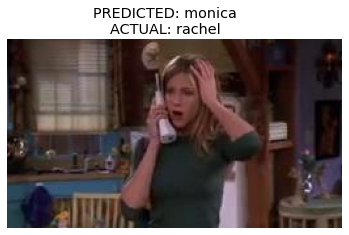

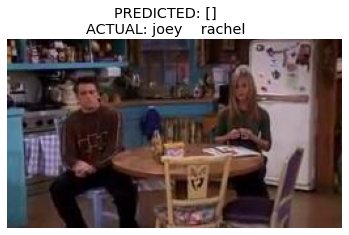

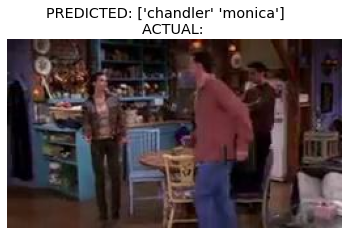

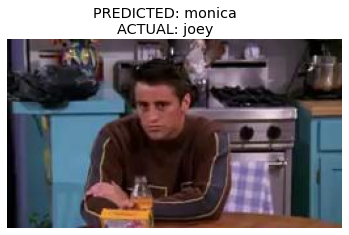

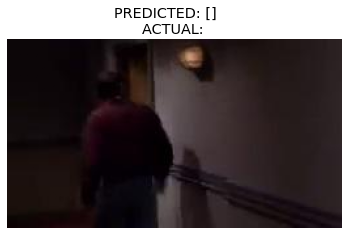

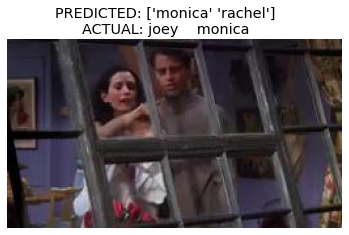

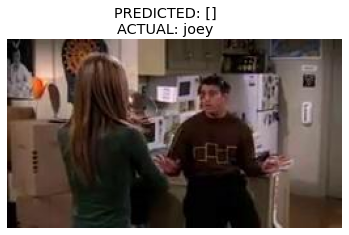

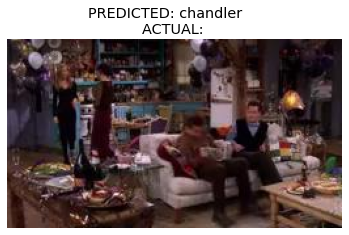

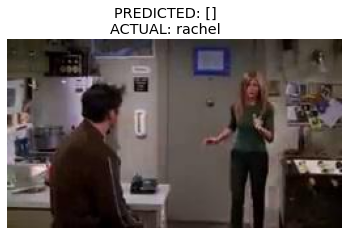

Test Error:  0.19875000558793546


In [53]:
model.eval()
test_running_error = 0.0
for counter, data in enumerate(test_loader):
    
    image, target = data["image"].to(device), data["label"]
    # get all the index positions where value == 1
    target_indices = [i for i in range(len(target[0])) if target[0][i] == 1]
#     print('target_indices: ', target_indices)
    # get the predictions by passing the image through the model
    outputs = model(image)
    outputs = torch.sigmoid(outputs)
    outputs = outputs.detach().cpu()
    lab = torch.where(outputs>=0.5,1,0)[0]
#     print('lab: ', lab)
    pred = torch.where(lab==1)
#     print('pred: ', pred)
    error = get_error( outputs, target, 1)
    #         print('error: ',error)
    test_running_error += error
    
    string_predicted = ""
    string_actual = ""
    for i in range(len(pred)):
        string_predicted += f"{actors[pred[i]]}    "
    for i in range(len(target_indices)):
        string_actual += f"{actors[target_indices[i]]}    "
        
#     print('image shape: ', image.shape)
    if 10< counter < 20:
        image = image.squeeze(0)
        image = image.detach().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
        plt.show()
    
test_error = test_running_error / counter
print(f"Test Error: ", test_error)